In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files # To Upload File from our computer

Please upload an image file (e.g., JPG, PNG).


Saving monkebajukuning.jpg to monkebajukuning (2).jpg
Attempting to display 'monkebajukuning (2).jpg' as a grayscale image.


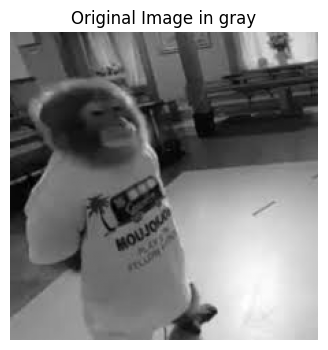

In [25]:
# Upload an image file
print("Please upload an image file (e.g., JPG, PNG).")
uploaded = files.upload()

# Get the filename and read the image in grayscale
filename = next(iter(uploaded))
original_image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

print(f"Attempting to display '{filename}' as a grayscale image.")

# Display image (use 4,4 to see much clearer on the difference of method)
plt.figure(figsize=(4, 4))
plt.imshow(original_image, cmap='gray')
plt.title("Original Image in gray")
plt.axis('off')
plt.show()

In [26]:
def downsample_average(img, factor):  #downsample using average method
    h, w = img.shape
    new_h = h // factor
    new_w = w // factor
    new_img = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            block = img[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            new_img[i, j] = np.mean(block) # Calculate the average of the block

    return new_img.astype(np.uint8)

In [27]:
def downsample_max(img, factor):
    h, w = img.shape
    new_h = h // factor
    new_w = w // factor
    new_img = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            block = img[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            new_img[i, j] = np.max(block) # Find the maximum value in the block

    return new_img


In [28]:
def downsample_median(img, factor):
    h, w = img.shape
    # FIX: Changed 'k' to 'factor'
    new_h = h // factor
    new_w = w // factor
    new_img = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            block = img[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            new_img[i, j] = np.median(block)

    return new_img

In [29]:
factor = 2 #to downsample half the size
avg_downsampled = downsample_average(original_image, factor)
max_downsampled = downsample_max(original_image, factor)
median_downsampled = downsample_median(original_image, factor)

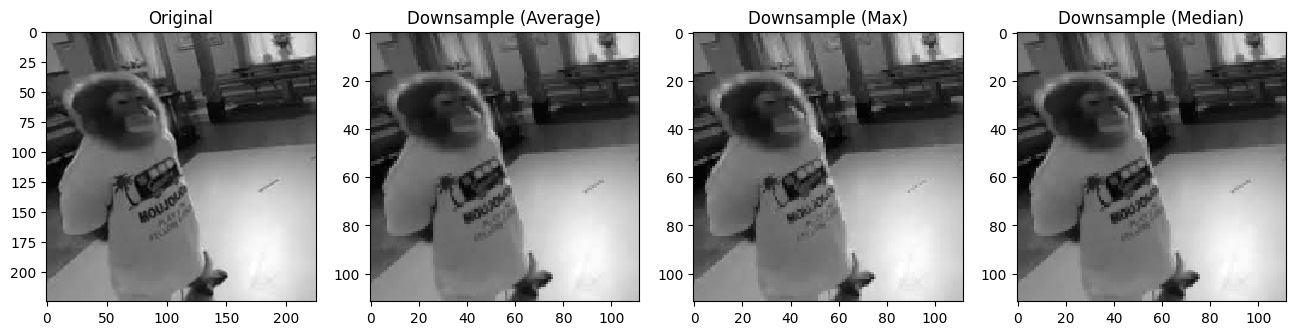

In [30]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(original_image, cmap='gray', interpolation='nearest')
plt.title("Original")

plt.subplot(1, 4, 2)
plt.imshow(avg_downsampled, cmap='gray', interpolation='nearest')
plt.title("Downsample (Average)")

plt.subplot(1, 4, 3)
plt.imshow(max_downsampled, cmap='gray', interpolation='nearest')
plt.title("Downsample (Max)")

plt.subplot(1, 4, 4)
plt.imshow(median_downsampled, cmap='gray', interpolation='nearest')
plt.title("Downsample (Median)")

plt.show()

In [31]:
import numpy as np

def upsample_nearest_neighbor(img, factor): #upsample using nearest neighbor method

    h, w = img.shape
    new_h, new_w = h * factor, w * factor
    new_img = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            # Find the corresponding pixel in the original image by integer division
            orig_i = i // factor
            orig_j = j // factor
            new_img[i, j] = img[orig_i, orig_j] # Assign the value of the nearest neighbor

    return new_img

In [32]:
def upsample_bilinear(img, factor): #upsample using bilinear method

    h, w = img.shape
    new_h, new_w = h * factor, w * factor
    new_img = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            # Map the new coordinates back to the original image's scale
            original_y = i / factor
            original_x = j / factor

            # Get the integer coordinates of the top-left pixel in the 2x2 grid
            y1, x1 = int(np.floor(original_y)), int(np.floor(original_x))

            # Get the coordinates of the other 3 surrounding pixels, clipping to avoid going out of bounds
            y2, x2 = min(y1 + 1, h - 1), min(x1 + 1, w - 1)

            # Get the pixel values of the 4 neighbors
            p1 = img[y1, x1] # Top-left
            p2 = img[y1, x2] # Top-right
            p3 = img[y2, x1] # Bottom-left
            p4 = img[y2, x2] # Bottom-right

            # Calculate the fractional distances (these are the weights)
            dy = original_y - y1
            dx = original_x - x1

            # Interpolate in the x-direction
            top_inter = p1 * (1 - dx) + p2 * dx
            bottom_inter = p3 * (1 - dx) + p4 * dx

            # Interpolate in the y-direction
            interpolated_val = top_inter * (1 - dy) + bottom_inter * dy
            new_img[i, j] = np.clip(interpolated_val, 0, 255)

    return new_img

In [33]:
def cubic_kernel(d): #define the cubic interpolation kernel
    d = np.abs(d)
    if d <= 1:
        return 1.5 * d**3 - 2.5 * d**2 + 1
    elif d <= 2:
        return -0.5 * d**3 + 2.5 * d**2 - 4 * d + 2
    else:
        return 0

def upsample_bicubic(img, factor): #upsample using bicubic method

    h, w = img.shape
    new_h, new_w = h * factor, w * factor
    new_img = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            original_y = i / factor
            original_x = j / factor
            y_floor = int(np.floor(original_y))
            x_floor = int(np.floor(original_x))
            dy = original_y - y_floor
            dx = original_x - x_floor

            interpolated_value = 0

            for m in range(-1, 3): # relative row index
                for n in range(-1, 3):
                    neighbor_y = np.clip(y_floor + m, 0, h - 1)
                    neighbor_x = np.clip(x_floor + n, 0, w - 1)

                    weight_y = cubic_kernel(m - dy)
                    weight_x = cubic_kernel(n - dx)

                    # Add the weighted pixel value to the total
                    interpolated_value += img[neighbor_y, neighbor_x] * weight_y * weight_x

            new_img[i, j] = np.clip(interpolated_value, 0, 255)

    return new_img

In [34]:
import matplotlib.pyplot as plt

upsample_factor = 2
source_image_for_upsampling = avg_downsampled

nn_upsampled = upsample_nearest_neighbor(source_image_for_upsampling, upsample_factor)
bilinear_upsampled = upsample_bilinear(source_image_for_upsampling, upsample_factor)
bicubic_upsampled = upsample_bicubic(source_image_for_upsampling, upsample_factor)

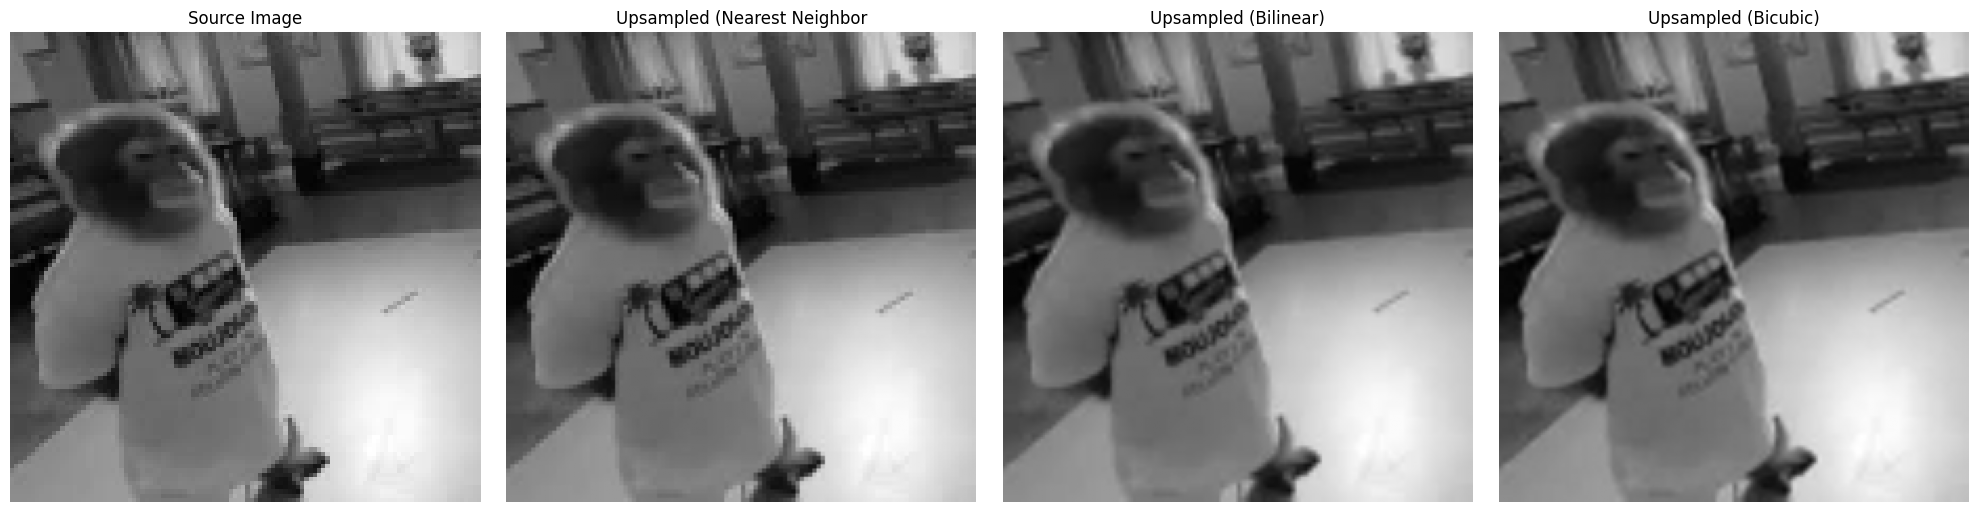

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(source_image_for_upsampling, cmap='gray')
plt.title("Source Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(nn_upsampled, cmap='gray')
plt.title("Upsampled (Nearest Neighbor")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(bilinear_upsampled, cmap='gray')
plt.title("Upsampled (Bilinear)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(bicubic_upsampled, cmap='gray')
plt.title("Upsampled (Bicubic)")
plt.axis('off')

plt.tight_layout()
plt.show()

Reference:
https://www.geeksforgeeks.org/python/spatial-resolution-down-sampling-and-up-sampling-in-image-processing/
https://www.geeksforgeeks.org/python/image-pyramid-using-opencv-python/